In [9]:
!pip install indic-nlp-library

In [10]:
import numpy as np
import pandas as pd
import tensorflow
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from string import digits
import nltk
from collections import Counter
import re
import string
from wordcloud import WordCloud
import seaborn as sns
from nltk.util import ngrams
nltk.download('punkt')  # Download necessary data for NLTK
from indicnlp.tokenize import sentence_tokenize, indic_tokenize
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-10-52b8e8e30f52>:23: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [11]:
def preprocess_text(text):
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove quotes
    text = re.sub("'", '', text)

    # Define a function to remove special characters
    def remove_special_characters(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    # Remove special characters
    text = remove_special_characters(text)

    # Define a function to remove digits
    def remove_digits(text):
        remove_digits = str.maketrans('', '', digits)
        return text.translate(remove_digits)

    # Remove digits
    text = remove_digits(text)

    # Remove specific Hindi digits
    text = re.sub("[२३०८१५७९४६]", "", text)

    # Remove extra spaces
    text = text.strip()
    text = re.sub(" +", " ", text)

    return text

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
lines = pd.read_csv('/content/drive/MyDrive/NLP Project/hindi_english_parallel.csv')
lines.shape

(1561841, 2)

In [14]:
lines = lines[:30000]
lines.head()

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,Give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,Accerciser Accessibility Explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है,A list of plugins that are disabled by default


In [15]:
lines.shape

(30000, 2)

In [16]:
lines.count()

hindi      29997
english    30000
dtype: int64

In [17]:
lines.isnull().sum()

hindi      3
english    0
dtype: int64

In [18]:
data=lines
data[data.columns[data.isnull().any()]].isnull().sum() * 100 / data.shape[0]

hindi    0.01
dtype: float64

In [19]:
lines.dropna(inplace=True)

In [20]:
lines.isnull().sum()

hindi      0
english    0
dtype: int64

In [21]:
lines.describe()

,hindi,english
count,29997,29997
unique,5006,6092
top,संपादक,_ Help
freq,62,39


In [22]:
lines.dtypes

hindi      object
english    object
dtype: object

In [23]:
pre_lines = lines[:30000]

In [24]:
pre_lines['english'] = lines['english'].apply(preprocess_text)
pre_lines['hindi'] = lines['hindi'].apply(preprocess_text)

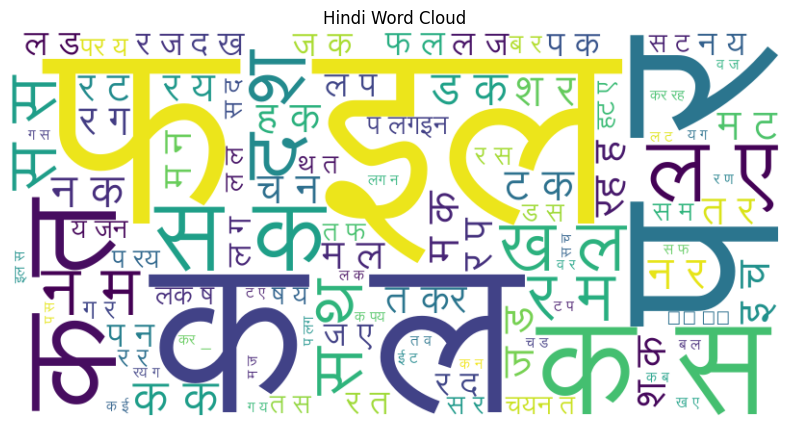

In [26]:
def tokenise_hindi(text):
    # Tokenize into words
    words = indic_tokenize.trivial_tokenize(text)
    return words
hindi_tokens = lines[['hindi']]
# Apply preprocessing to the Hindi column and create a new column
hindi_tokens['tokens'] = lines['hindi'].apply(tokenise_hindi)

# Create a word cloud for Hindi
hindi_wordcloud = WordCloud(font_path='/content/drive/MyDrive/NLP Project/Lohit-Devanagari.ttf',width=800, height=400, background_color='white', max_words=100).generate(' '.join(hindi_tokens['tokens'].apply(' '.join)))
plt.figure(figsize=(10, 5))
plt.imshow(hindi_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Hindi Word Cloud')
plt.show()


In [27]:
hindi_tokens

,hindi,tokens
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,"[अपने, अनुप्रयोग, को, पहुंचनीयता, व्यायाम, का, लाभ, दें]"
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,"[एक्सेर्साइसर, पहुंचनीयता, अन्वेषक]"
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,"[निचले, पटल, के, लिए, डिफोल्ट, प्लग, -, इन, खाका]"
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,"[ऊपरी, पटल, के, लिए, डिफोल्ट, प्लग, -, इन, खाका]"
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है,"[उन, प्लग, -, इनों, की, सूची, जिन्हें, डिफोल्ट, रूप, से, निष्क्रिय, किया, गया, है]"
...,...,...
29995,% s आयात करें (_ m),"[%, s, आयात, करें, (, _, m, )]"
29996,आयात करें (_ m),"[आयात, करें, (, _, m, )]"
29997,क्या आप '% s' से सत्र आयात करना चाहते हैं?,"[क्या, आप, ', %, s, ', से, सत्र, आयात, करना, चाहते, हैं, ?]"
29998,"उस तरह से, पिछले सत्र से पुरानी फाइलें लिखने के बाद प्रयोग लायक होगी.","[उस, तरह, से, ,, पिछले, सत्र, से, पुरानी, फाइलें, लिखने, के, बाद, प्रयोग, लायक, होगी, .]"


In [28]:
# Lowercase all character
lines['english']=lines['english'].apply(lambda x: str(x))
lines['hindi']=lines['hindi'].apply(lambda x: str(x))
lines['english']=lines['english'].apply(lambda x: x.lower())
lines['hindi']=lines['hindi'].apply(lambda x: x.lower())

In [29]:
lines['hindi'][0]

'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'

In [30]:
# Remove quotes
lines['english']=lines['english'].apply(lambda x: re.sub("'", '', x))
lines['hindi']=lines['hindi'].apply(lambda x: re.sub("'", '', x))

In [31]:
lines.head()

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,accerciser accessibility explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,the default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,the default plugin layout for the top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है,a list of plugins that are disabled by default


In [32]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['english']=lines['english'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi']=lines['hindi'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [33]:
lines.head()

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,accerciser accessibility explorer
2,निचले पटल के लिए डिफोल्ट प्लगइन खाका,the default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका,the default plugin layout for the top panel
4,उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है,a list of plugins that are disabled by default


In [34]:
remove_digits = str.maketrans('', '', digits)

In [35]:
remove_digits

{48: None,
 49: None,
 50: None,
 51: None,
 52: None,
 53: None,
 54: None,
 55: None,
 56: None,
 57: None}

In [36]:
a = lines['english'][0].translate(remove_digits)

In [37]:
a

'give your application an accessibility workout'

In [38]:
a.strip()

'give your application an accessibility workout'

In [39]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['english']=lines['english'].apply(lambda x: x.translate(remove_digits))
lines['hindi']=lines['hindi'].apply(lambda x: x.translate(remove_digits))

lines['hindi'] = lines['hindi'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
lines['english']=lines['english'].apply(lambda x: x.strip())
lines['hindi']=lines['hindi'].apply(lambda x: x.strip())
lines['english']=lines['english'].apply(lambda x: re.sub(" +", " ", x))
lines['hindi']=lines['hindi'].apply(lambda x: re.sub(" +", " ", x))

In [40]:
lines['english'][0]

'give your application an accessibility workout'

In [41]:
# Create a new DataFrame to store the statistics
statistics = pd.DataFrame()

# Calculate the number of words in English and Hindi sentences
statistics['english_word_count'] = lines['english'].apply(lambda x: len(x.split()))
statistics['hindi_word_count'] = lines['hindi'].apply(lambda x: len(x.split()))

# Calculate the average word count for English and Hindi sentences
statistics['english_avg_word_count'] = statistics['english_word_count'].mean()
statistics['hindi_avg_word_count'] = statistics['hindi_word_count'].mean()

# Calculate the maximum word count for English and Hindi sentences
statistics['english_max_word_count'] = statistics['english_word_count'].max()
statistics['hindi_max_word_count'] = statistics['hindi_word_count'].max()

# Calculate the minimum word count for English and Hindi sentences
statistics['english_min_word_count'] = statistics['english_word_count'].min()
statistics['hindi_min_word_count'] = statistics['hindi_word_count'].min()

# Display the statistics
print(statistics)


       english_word_count  hindi_word_count  english_avg_word_count  hindi_avg_word_count  english_max_word_count  hindi_max_word_count  english_min_word_count  hindi_min_word_count
0      6                   8                 3.6622                  3.518185              68                      76                    0                       0                   
1      3                   3                 3.6622                  3.518185              68                      76                    0                       0                   
2      8                   7                 3.6622                  3.518185              68                      76                    0                       0                   
3      8                   7                 3.6622                  3.518185              68                      76                    0                       0                   
4      9                   12                3.6622                  3.518185             

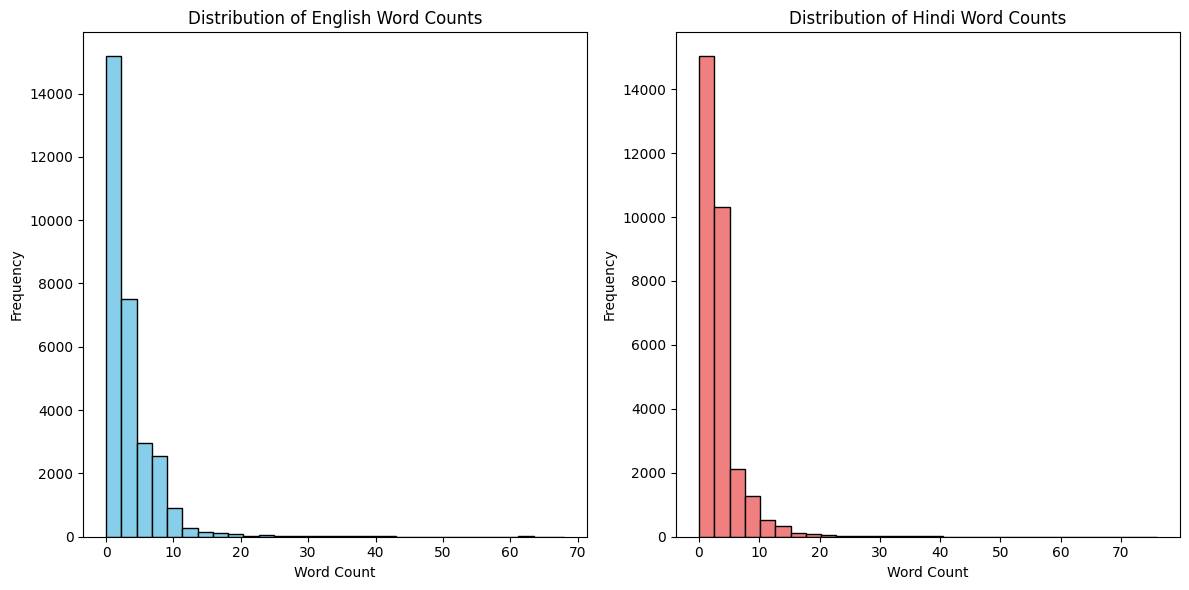

In [42]:
# Plot the distribution of English word counts
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(statistics['english_word_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of English Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Plot the distribution of Hindi word counts
plt.subplot(1, 2, 2)
plt.hist(statistics['hindi_word_count'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Hindi Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Inference:
english & Hindi words are balanced

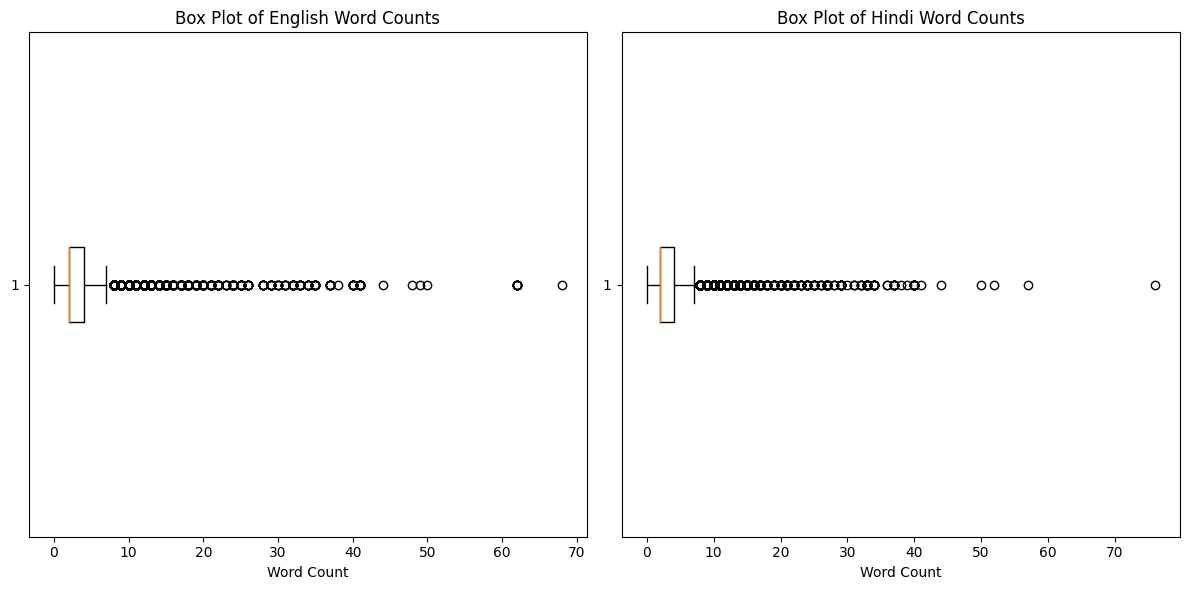

In [43]:
# Create box plots for word counts
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot(statistics['english_word_count'], vert=False)
plt.title('Box Plot of English Word Counts')
plt.xlabel('Word Count')

plt.subplot(1, 2, 2)
plt.boxplot(statistics['hindi_word_count'], vert=False)
plt.title('Box Plot of Hindi Word Counts')
plt.xlabel('Word Count')

plt.tight_layout()
plt.show()


In [44]:
def extract_ngrams(text, n):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Create n-grams
    n_grams = list(ngrams(words, n))

    return n_grams


In [45]:
hindi_tokens

,hindi,tokens
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,"[अपने, अनुप्रयोग, को, पहुंचनीयता, व्यायाम, का, लाभ, दें]"
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,"[एक्सेर्साइसर, पहुंचनीयता, अन्वेषक]"
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,"[निचले, पटल, के, लिए, डिफोल्ट, प्लग, -, इन, खाका]"
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,"[ऊपरी, पटल, के, लिए, डिफोल्ट, प्लग, -, इन, खाका]"
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है,"[उन, प्लग, -, इनों, की, सूची, जिन्हें, डिफोल्ट, रूप, से, निष्क्रिय, किया, गया, है]"
...,...,...
29995,% s आयात करें (_ m),"[%, s, आयात, करें, (, _, m, )]"
29996,आयात करें (_ m),"[आयात, करें, (, _, m, )]"
29997,क्या आप '% s' से सत्र आयात करना चाहते हैं?,"[क्या, आप, ', %, s, ', से, सत्र, आयात, करना, चाहते, हैं, ?]"
29998,"उस तरह से, पिछले सत्र से पुरानी फाइलें लिखने के बाद प्रयोग लायक होगी.","[उस, तरह, से, ,, पिछले, सत्र, से, पुरानी, फाइलें, लिखने, के, बाद, प्रयोग, लायक, होगी, .]"


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

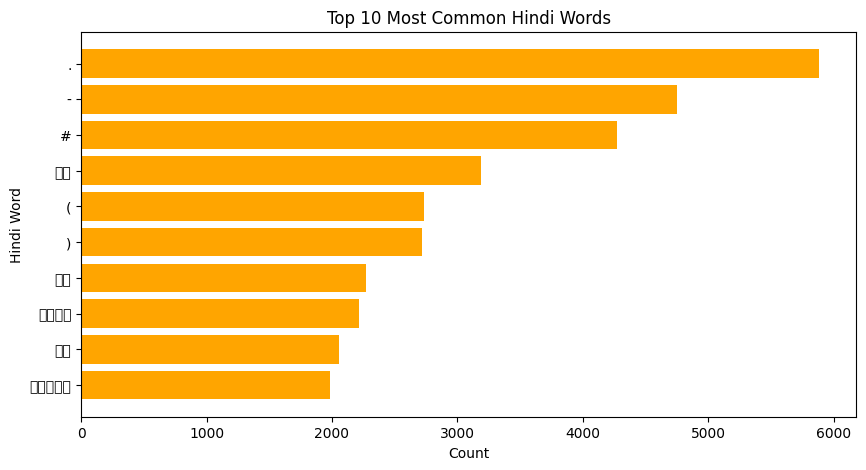

In [46]:
# Count word frequencies in Hindi text
hindi_word_frequencies = Counter([word for sublist in hindi_tokens['tokens'] for word in sublist])

# Plot the most common Hindi words
common_words, word_counts = zip(*hindi_word_frequencies.most_common(10))

plt.figure(figsize=(10, 5))
plt.barh(common_words, word_counts, color='orange')
plt.xlabel('Count')
plt.ylabel('Hindi Word')
plt.title('Top 10 Most Common Hindi Words')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most common words at the top

plt.show()

In [47]:
n_grams_lines = lines.copy()
n_grams_lines['english_bigrams'] = lines['english'].apply(lambda x: extract_ngrams(x, 2))
n_grams_lines['hindi_bigrams'] = lines['hindi'].apply(lambda x: extract_ngrams(x, 2))

n_grams_lines['english_trigrams'] = lines['english'].apply(lambda x: extract_ngrams(x, 3))
n_grams_lines['hindi_trigrams'] = lines['hindi'].apply(lambda x: extract_ngrams(x, 3))

# Print the DataFrame to see the new columns
n_grams_lines.head()

,hindi,english,english_bigrams,hindi_bigrams,english_trigrams,hindi_trigrams
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,give your application an accessibility workout,"[(give, your), (your, application), (application, an), (an, accessibility), (accessibility, workout)]","[(अपने, अनुप्रयोग), (अनुप्रयोग, को), (को, पहुंचनीयता), (पहुंचनीयता, व्यायाम), (व्यायाम, का), (का, लाभ), (लाभ, दें)]","[(give, your, application), (your, application, an), (application, an, accessibility), (an, accessibility, workout)]","[(अपने, अनुप्रयोग, को), (अनुप्रयोग, को, पहुंचनीयता), (को, पहुंचनीयता, व्यायाम), (पहुंचनीयता, व्यायाम, का), (व्यायाम, का, लाभ), (का, लाभ, दें)]"
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,accerciser accessibility explorer,"[(accerciser, accessibility), (accessibility, explorer)]","[(एक्सेर्साइसर, पहुंचनीयता), (पहुंचनीयता, अन्वेषक)]","[(accerciser, accessibility, explorer)]","[(एक्सेर्साइसर, पहुंचनीयता, अन्वेषक)]"
2,निचले पटल के लिए डिफोल्ट प्लगइन खाका,the default plugin layout for the bottom panel,"[(the, default), (default, plugin), (plugin, layout), (layout, for), (for, the), (the, bottom), (bottom, panel)]","[(निचले, पटल), (पटल, के), (के, लिए), (लिए, डिफोल्ट), (डिफोल्ट, प्लगइन), (प्लगइन, खाका)]","[(the, default, plugin), (default, plugin, layout), (plugin, layout, for), (layout, for, the), (for, the, bottom), (the, bottom, panel)]","[(निचले, पटल, के), (पटल, के, लिए), (के, लिए, डिफोल्ट), (लिए, डिफोल्ट, प्लगइन), (डिफोल्ट, प्लगइन, खाका)]"
3,ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका,the default plugin layout for the top panel,"[(the, default), (default, plugin), (plugin, layout), (layout, for), (for, the), (the, top), (top, panel)]","[(ऊपरी, पटल), (पटल, के), (के, लिए), (लिए, डिफोल्ट), (डिफोल्ट, प्लगइन), (प्लगइन, खाका)]","[(the, default, plugin), (default, plugin, layout), (plugin, layout, for), (layout, for, the), (for, the, top), (the, top, panel)]","[(ऊपरी, पटल, के), (पटल, के, लिए), (के, लिए, डिफोल्ट), (लिए, डिफोल्ट, प्लगइन), (डिफोल्ट, प्लगइन, खाका)]"
4,उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है,a list of plugins that are disabled by default,"[(a, list), (list, of), (of, plugins), (plugins, that), (that, are), (are, disabled), (disabled, by), (by, default)]","[(उन, प्लगइनों), (प्लगइनों, की), (की, सूची), (सूची, जिन्हें), (जिन्हें, डिफोल्ट), (डिफोल्ट, रूप), (रूप, से), (से, निष्क्रिय), (निष्क्रिय, किया), (किया, गया), (गया, है)]","[(a, list, of), (list, of, plugins), (of, plugins, that), (plugins, that, are), (that, are, disabled), (are, disabled, by), (disabled, by, default)]","[(उन, प्लगइनों, की), (प्लगइनों, की, सूची), (की, सूची, जिन्हें), (सूची, जिन्हें, डिफोल्ट), (जिन्हें, डिफोल्ट, रूप), (डिफोल्ट, रूप, से), (रूप, से, निष्क्रिय), (से, निष्क्रिय, किया), (निष्क्रिय, किया, गया), (किया, गया, है)]"


<ipython-input-48-d6d8dffbb28f>:35: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  plt.tight_layout()
<ipython-input-48-d6d8dffbb28f>:35: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
<ipython-input-48-d6d8dffbb28f>:35: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  plt.tight_layout()
<ipython-input-48-d6d8dffbb28f>:35: UserWarning: Glyph 2354 (\N{DEVANAGARI LETTER LA}) missing from current font.
  plt.tight_layout()
<ipython-input-48-d6d8dffbb28f>:35: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  plt.tight_layout()
<ipython-input-48-d6d8dffbb28f>:35: UserWarning: Glyph 2319 (\N{DEVANAGARI LETTER E}) missing from current font.
  plt.tight_layout()
<ipython-input-48-d6d8dffbb28f>:35: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from current font.
  plt.tight_layout()
<ipython-input-48-d6d8dffbb28f>:35: UserWarning: Glyph 2

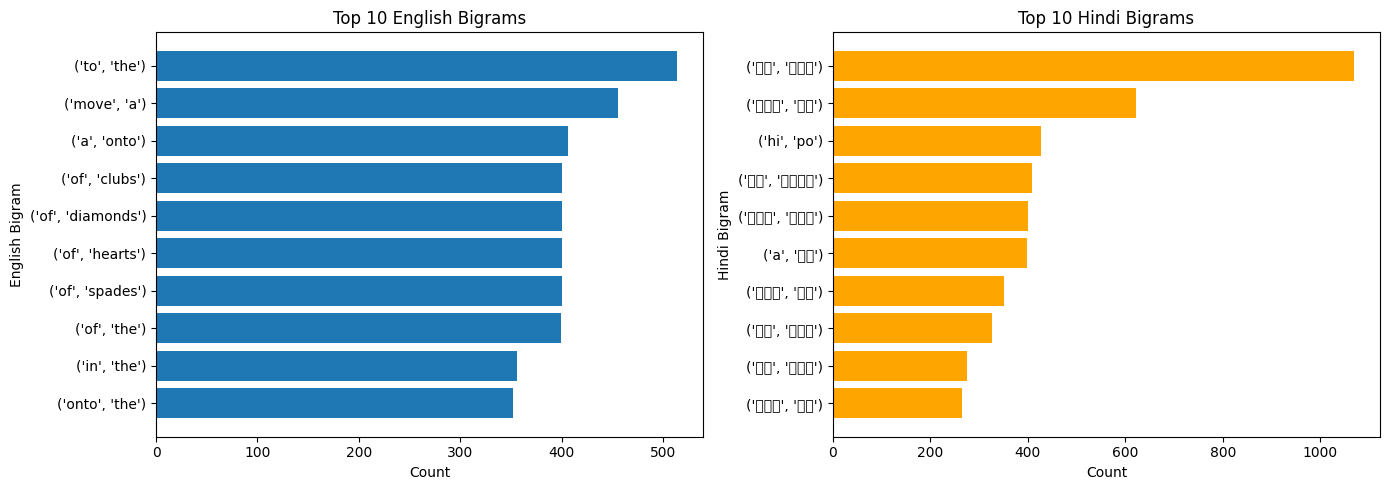

In [48]:
# English Bigrams
english_bigrams = [str(bigram) for sublist in n_grams_lines['english_bigrams'] for bigram in sublist]
english_bigram_counts = Counter(english_bigrams)
most_common_english_bigrams = english_bigram_counts.most_common(10)

english_bigrams, english_counts = zip(*most_common_english_bigrams)
font_path='/content/drive/MyDrive/NLP Project/Lohit-Devanagari.ttf'

# Hindi Bigrams
hindi_bigrams = [str(bigram) for sublist in n_grams_lines['hindi_bigrams'] for bigram in sublist]
hindi_bigram_counts = Counter(hindi_bigrams)
most_common_hindi_bigrams = hindi_bigram_counts.most_common(10)

hindi_bigrams, hindi_counts = zip(*most_common_hindi_bigrams)

# Create plots for English and Hindi Bigrams
plt.figure(figsize=(14, 5))

# Plot for English Bigrams
plt.subplot(121)
plt.barh(english_bigrams, english_counts)
plt.xlabel('Count')
plt.ylabel('English Bigram')
plt.title('Top 10 English Bigrams')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most common bigram at the top

# Plot for Hindi Bigrams
plt.subplot(122)
plt.barh(hindi_bigrams, hindi_counts, color='orange')
plt.xlabel('Count')
plt.ylabel('Hindi Bigram')
plt.title('Top 10 Hindi Bigrams')  # Use the Hindi font
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [49]:
hindi_bigrams = [str(bigram) for sublist in n_grams_lines['hindi_bigrams'] for bigram in sublist]
hindi_bigram_counts = Counter(hindi_bigrams)
most_common_hindi_bigrams = hindi_bigram_counts.most_common(20)

In [50]:
hindi_bigrams

["('अपने', 'अनुप्रयोग')",
 "('अनुप्रयोग', 'को')",
 "('को', 'पहुंचनीयता')",
 "('पहुंचनीयता', 'व्यायाम')",
 "('व्यायाम', 'का')",
 "('का', 'लाभ')",
 "('लाभ', 'दें')",
 "('एक्सेर्साइसर', 'पहुंचनीयता')",
 "('पहुंचनीयता', 'अन्वेषक')",
 "('निचले', 'पटल')",
 "('पटल', 'के')",
 "('के', 'लिए')",
 "('लिए', 'डिफोल्ट')",
 "('डिफोल्ट', 'प्लगइन')",
 "('प्लगइन', 'खाका')",
 "('ऊपरी', 'पटल')",
 "('पटल', 'के')",
 "('के', 'लिए')",
 "('लिए', 'डिफोल्ट')",
 "('डिफोल्ट', 'प्लगइन')",
 "('प्लगइन', 'खाका')",
 "('उन', 'प्लगइनों')",
 "('प्लगइनों', 'की')",
 "('की', 'सूची')",
 "('सूची', 'जिन्हें')",
 "('जिन्हें', 'डिफोल्ट')",
 "('डिफोल्ट', 'रूप')",
 "('रूप', 'से')",
 "('से', 'निष्क्रिय')",
 "('निष्क्रिय', 'किया')",
 "('किया', 'गया')",
 "('गया', 'है')",
 "('अवधि', 'को')",
 "('को', 'हाइलाइट')",
 "('हाइलाइट', 'रकें')",
 "('पहुंचनीय', 'आसंधि')",
 "('आसंधि', 'नोड')",
 "('नोड', 'को')",
 "('को', 'चुनते')",
 "('चुनते', 'समय')",
 "('समय', 'हाइलाइट')",
 "('हाइलाइट', 'बक्से')",
 "('बक्से', 'की')",
 "('की', 'अवधि')",
 "('सीमांत'

In [51]:
hindi_counts

(1069, 622, 426, 408, 401, 399, 352, 326, 276, 264)

In [52]:
# add start and end tokens to target sequences
lines['hindi'] = lines['hindi'].apply(lambda x: 'START_ '+ x + ' _END')

In [53]:
lines['hindi'][0]

'START_ अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें _END'

In [54]:
### Get English and Hindi Vocabulary
all_eng_words=set()
for eng in lines['english']:
  for word in eng.split():
    if word not in all_eng_words:
        all_eng_words.add(word)

all_hindi_words=set()
for hin in lines['hindi']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)

In [55]:
all_eng_words.add(word)

In [56]:
all_hindi_words.add(word)

In [57]:
lines.head()

,hindi,english
0,START_ अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें _END,give your application an accessibility workout
1,START_ एक्सेर्साइसर पहुंचनीयता अन्वेषक _END,accerciser accessibility explorer
2,START_ निचले पटल के लिए डिफोल्ट प्लगइन खाका _END,the default plugin layout for the bottom panel
3,START_ ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका _END,the default plugin layout for the top panel
4,START_ उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है _END,a list of plugins that are disabled by default


In [58]:
lines['length_eng']=lines['english'].apply(lambda x:len(x.split(" ")))
lines['length_hin']=lines['hindi'].apply(lambda x:len(x.split(" ")))

In [59]:
lines.head()

,hindi,english,length_eng,length_hin
0,START_ अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें _END,give your application an accessibility workout,6,10
1,START_ एक्सेर्साइसर पहुंचनीयता अन्वेषक _END,accerciser accessibility explorer,3,5
2,START_ निचले पटल के लिए डिफोल्ट प्लगइन खाका _END,the default plugin layout for the bottom panel,8,9
3,START_ ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका _END,the default plugin layout for the top panel,8,9
4,START_ उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है _END,a list of plugins that are disabled by default,9,14


In [60]:
lines=lines[lines['length_eng']<=20]
lines=lines[lines['length_hin']<=20]

In [61]:
print("maximum length of Hindi Sentence ", max(lines['length_hin']))
print("maximum length of English Sentence ", max(lines['length_eng']))

maximum length of Hindi Sentence  20
maximum length of English Sentence  20


In [62]:
max_length_src=max(lines['length_hin'])
max_length_tar=max(lines['length_eng'])

In [63]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hindi_words)
num_encoder_tokens, num_decoder_tokens

(2688, 3437)

In [64]:
num_decoder_tokens += 1

In [65]:
num_decoder_tokens

3438

In [66]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [67]:
input_token_index

{'_END': 1,
 'a': 2,
 'able': 3,
 'abort': 4,
 'aborted': 5,
 'about': 6,
 'above': 7,
 'absolute': 8,
 'ac': 9,
 'accelerator': 10,
 'accelerator…': 11,
 'accentuated': 12,
 'accept': 13,
 'acceptable': 14,
 'accepted': 15,
 'accerciser': 16,
 'access': 17,
 'accessed': 18,
 'accessibility': 19,
 'accessible': 20,
 'accessibles': 21,
 'according': 22,
 'accordion': 23,
 'ace': 24,
 'aces': 25,
 'across': 26,
 'act': 27,
 'acti': 28,
 'action': 29,
 'actionable': 30,
 'actions': 31,
 'activatable': 32,
 'activate': 33,
 'activated': 34,
 'active': 35,
 'actual': 36,
 'adaptive': 37,
 'add': 38,
 'added': 39,
 'addition': 40,
 'additional': 41,
 'addrcheck': 42,
 'address': 43,
 'addressbook': 44,
 'addresses': 45,
 'adds': 46,
 'add…': 47,
 'advance': 48,
 'advanced': 49,
 'advised': 50,
 'affects': 51,
 'after': 52,
 'again': 53,
 'against': 54,
 'agnes': 55,
 'aim': 56,
 'aisleriot': 57,
 'al': 58,
 'albert': 59,
 'alert': 60,
 'algorithm': 61,
 'alidate': 62,
 'all': 63,
 'alleys': 

In [68]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [69]:
reverse_input_char_index

{1: '_END',
 2: 'a',
 3: 'able',
 4: 'abort',
 5: 'aborted',
 6: 'about',
 7: 'above',
 8: 'absolute',
 9: 'ac',
 10: 'accelerator',
 11: 'accelerator…',
 12: 'accentuated',
 13: 'accept',
 14: 'acceptable',
 15: 'accepted',
 16: 'accerciser',
 17: 'access',
 18: 'accessed',
 19: 'accessibility',
 20: 'accessible',
 21: 'accessibles',
 22: 'according',
 23: 'accordion',
 24: 'ace',
 25: 'aces',
 26: 'across',
 27: 'act',
 28: 'acti',
 29: 'action',
 30: 'actionable',
 31: 'actions',
 32: 'activatable',
 33: 'activate',
 34: 'activated',
 35: 'active',
 36: 'actual',
 37: 'adaptive',
 38: 'add',
 39: 'added',
 40: 'addition',
 41: 'additional',
 42: 'addrcheck',
 43: 'address',
 44: 'addressbook',
 45: 'addresses',
 46: 'adds',
 47: 'add…',
 48: 'advance',
 49: 'advanced',
 50: 'advised',
 51: 'affects',
 52: 'after',
 53: 'again',
 54: 'against',
 55: 'agnes',
 56: 'aim',
 57: 'aisleriot',
 58: 'al',
 59: 'albert',
 60: 'alert',
 61: 'algorithm',
 62: 'alidate',
 63: 'all',
 64: 'alley

In [70]:
lines.head(10)

,hindi,english,length_eng,length_hin
0,START_ अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें _END,give your application an accessibility workout,6,10
1,START_ एक्सेर्साइसर पहुंचनीयता अन्वेषक _END,accerciser accessibility explorer,3,5
2,START_ निचले पटल के लिए डिफोल्ट प्लगइन खाका _END,the default plugin layout for the bottom panel,8,9
3,START_ ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका _END,the default plugin layout for the top panel,8,9
4,START_ उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है _END,a list of plugins that are disabled by default,9,14
5,START_ अवधि को हाइलाइट रकें _END,highlight duration,2,6
6,START_ पहुंचनीय आसंधि नोड को चुनते समय हाइलाइट बक्से की अवधि _END,the duration of the highlight box when selecting accessible nodes,10,12
7,START_ सीमांत बोर्डर के रंग को हाइलाइट करें _END,highlight border color,3,9
8,START_ हाइलाइट किए गए सीमांत का रंग और अपारदर्शिता। _END,the color and opacity of the highlight border,8,10
9,START_ भराई के रंग को हाइलाइट करें _END,highlight fill color,3,8


In [71]:
from sklearn.model_selection import train_test_split
X, y = lines['english'], lines['hindi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape

((23709,), (5928,))

In [72]:
X_train.head()

17626    rebase against selected remote  
2100     move a onto the jack of diamonds
15131    run continue                    
23936    working directory               
16778    gobject classt                  
Name: english, dtype: object

In [73]:
encoder_input_data = np.zeros((2, max_length_src),dtype='float32')
decoder_input_data = np.zeros((2, max_length_tar),dtype='float32')
decoder_target_data = np.zeros((2, max_length_tar, num_decoder_tokens),dtype='float32')

In [74]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):

                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [75]:
encoder_input_data

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)

In [76]:
decoder_input_data

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)

In [77]:
decoder_target_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [78]:
latent_dim = 300
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens+1, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [79]:
encoder_inputs

<KerasTensor: shape=(None, None) dtype=float32 (created by layer 'input_1')>

In [80]:
encoder_outputs

<KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'lstm')>

In [81]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(num_decoder_tokens+1, latent_dim, mask_zero = True)

dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [82]:
decoder_outputs

<KerasTensor: shape=(None, None, 3438) dtype=float32 (created by layer 'dense')>

In [83]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [84]:
model.summary()
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 64
epochs = 25

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 300)            806700    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 300)            1031700   ['input_2[0][0]']             
                                                                                              

In [85]:
a, b = next(generate_batch())

In [86]:
b

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [87]:
X_train[4]

'a list of plugins that are disabled by default'

In [88]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples/batch_size,
                    epochs=25,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples/batch_size)

Epoch 1/25


<ipython-input-88-0b9b99fbc836>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),


370/370 [==============================] - 58s 115ms/step - loss: 5.0143 - accuracy: 0.2572 - val_loss: 4.1645 - val_accuracy: 0.3163
Epoch 2/25
370/370 [==============================] - 21s 58ms/step - loss: 3.4737 - accuracy: 0.4014 - val_loss: 2.8374 - val_accuracy: 0.4859
Epoch 3/25
370/370 [==============================] - 18s 49ms/step - loss: 2.1883 - accuracy: 0.5900 - val_loss: 1.7877 - val_accuracy: 0.6714
Epoch 4/25
370/370 [==============================] - 18s 49ms/step - loss: 1.2866 - accuracy: 0.7594 - val_loss: 1.1860 - val_accuracy: 0.8020
Epoch 5/25
370/370 [==============================] - 20s 54ms/step - loss: 0.8093 - accuracy: 0.8514 - val_loss: 0.9068 - val_accuracy: 0.8539
Epoch 6/25
370/370 [==============================] - 18s 49ms/step - loss: 0.5723 - accuracy: 0.8910 - val_loss: 0.7752 - val_accuracy: 0.8783
Epoch 7/25
370/370 [==============================] - 19s 51ms/step - loss: 0.4227 - accuracy: 0.9154 - val_loss: 0.6993 - val_accuracy: 0.8899
Ep

In [89]:
model.save('eng-to-hindi.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [90]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

### Decoder part of Sequence to Sequence Model

In [91]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [92]:
decoder_states_inputs

[<KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_4')>]

In [93]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [94]:
next(train_gen)

([array([[1859.,   54., 2064., 1916.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.]], dtype=float32),
  array([[1.000e+00, 1.243e+03, 2.651e+03, 0.000e+00, 0.000e+00, 0.000e+00,
          0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
          0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
          0.000e+00, 0.000e+00]], dtype=float32)],
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32))

In [95]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 38ms/step
Input English sentence: rebase against selected remote
Actual Hindi Translation:  चयनित रिमोट 
Predicted Hindi Translation:  a को एक ईंट का गुलाम पर ले जाएँ 


In [96]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 35ms/step
Input English sentence: move a onto the jack of diamonds
Actual Hindi Translation:  a को एक ईंट का गुलाम पर ले जाएँ 
Predicted Hindi Translation:  चलाएँ जारी रखें 


In [97]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 39ms/step
Input English sentence: run continue
Actual Hindi Translation:  चलाएँ जारी रखें 
Predicted Hindi Translation:  कार्यशील निर्देशिकाः 


In [98]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 37ms/step
Input English sentence: working directory
Actual Hindi Translation:  कार्यशील निर्देशिकाः 
Predicted Hindi Translation:  gobject classt 


In [99]:
print(X_train.values[0])

rebase against selected remote


In [100]:
model.save('/content/drive/MyDrive/NLP Project/eng-hindi.h5')

In [101]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [102]:
history = model.history

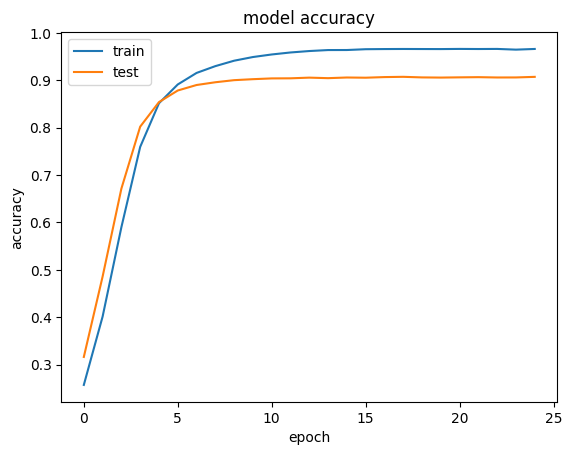

In [103]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

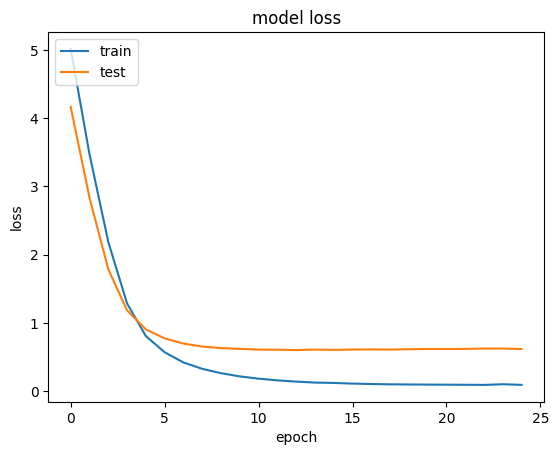

In [104]:
 # summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [105]:
encoder_model.save('/content/drive/MyDrive/NLP Project/encoder_model.h5')

In [106]:
decoder_model.save('/content/drive/MyDrive/NLP Project/decoder_model.h5')

In [107]:
type(train_gen)

generator

In [108]:
from tensorflow.keras.models import load_model

In [109]:
encoder = load_model('/content/drive/MyDrive/NLP Project/encoder_model.h5')
decoder = load_model('/content/drive/MyDrive/NLP Project/decoder_model.h5')

IndexError: ignored